# Project milestone 3

This last notebook presents the final results of our work. After producing a detailed analysis of the different datasets, we focused our analysis on three datasets to produce the most optimal analysis and presentation of results.
These datasets are:
* Stack Overflow
* Wikipedia
* [Crowdedness at the Gym Campus](https://www.kaggle.com/nsrose7224/crowdedness-at-the-campus-gym/version/2)


These three datasets allow us to find the same trends that we will present below.
A report is also available here offering a more detailed and organized analysis.
Hoping that you will enjoy our work.

In [1]:
import re
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime, timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Daylight Saving Time impact on Stack Overflow posts

We first want to make use of the Stack Overflow dataset provided for the third homework and squeeze as much intel from it as we can. We will assume that most of the posts are from US users, therefore we will look at the summer and winter hour changes in the US.

We first need to download the dataset.

In [ ]:
# Download the Posts data set (the same as the one in the homework 3)
!wget 'https://iloveadatas.com/datasets/Posts.json.zip'

In [ ]:
# Unzip it
!unzip Posts.json.zip

Having downloaded the dataset, we can now start the analysis.

In [2]:
# Load the data
DATA_PATH = "Posts.json"
posts_df = spark.read.json(DATA_PATH)

In [3]:
# Show the schema and some rows
posts_df.printSchema()

posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|

In [4]:
# Let's quickly change the type of the CreationDate column to Time
posts_df = posts_df.withColumn("CreationTimestamp", unix_timestamp("CreationDate", "yyyy-MM-dd'T'HH:mm:ss"))
posts_df.printSchema()
posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- CreationTimestamp: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|CreationTimestamp|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|       1288055875|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|       1288055897|
|2010-10-26

In [ ]:
# Save data to Parquet format
posts_df.write.parquet("stack.parquet")

In [5]:
# read the Parquet file and create a temporary Posts view to run
# arbitrary SQL queries
parquet_file = spark.read.parquet("stack.parquet")
parquet_file.createOrReplaceTempView("Posts")

### 1. Finding the shifts

We will visualize the distribution of the posts for the period around the winter hour change in the US.

The first thing to do is to determine what period our data extends over.

In [6]:
# Determine the time interval for the data
dates = spark.sql("SELECT MIN(CreationDate), MAX(CreationDate) FROM Posts")
dates.show()

+--------------------+--------------------+
|   min(CreationDate)|   max(CreationDate)|
+--------------------+--------------------+
|2008-07-31T22:08:...|2018-09-02T05:46:...|
+--------------------+--------------------+



We see that we have data from summer 2008 up to autumn 2018. We will then analyze summer hour changes for the years 2009-2018 and winter hour changes for the years 2008-2017. At each hour chage, we will consider data for a month before and a month after the change.

In [7]:
# Summer and winter hour change timestamps
summer_change = [1236470400, 1268524800, 1299974400, 1331424000, 1362873600,
                 1394323200, 1425772800, 1457827200, 1489276800, 1520726400]
winter_change = [1225584000, 1257033600, 1289088000, 1320537600, 1351987200,
                1383436800, 1414886400, 1446336000, 1478390400, 1509840000]

# Day duration and hour duration in seconds
HOUR_TIMESTAMP = 3600
DAY_TIMESTAMP = 24 * HOUR_TIMESTAMP

In [8]:
def hour_change_stats(summer_change, winter_change, days):
    '''
    Collect data for all the summer and winter hour changes
    input:  summer_change - timestamps for summer hour change
            winter_change - timestamps for winter hour change
            days - number of days to look before and after each hour change
    output: dataframes containing visits before and after hour changes
    
    '''
    summer_dfs = []
    winter_dfs = []

    def get_posts(change_timestamp):
        before = change_timestamp - days * DAY_TIMESTAMP - HOUR_TIMESTAMP
        after = change_timestamp + days * DAY_TIMESTAMP - HOUR_TIMESTAMP
        posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
                DATE_FORMAT(FROM_UNIXTIME(CreationTimestamp), "yyyy-MM-dd'T'HH") as Date,
                SUM(Score) AS TotalScore
                FROM Posts
                WHERE Posts.CreationTimestamp >= {before}
                    AND Posts.CreationTimestamp <= {after}
                GROUP BY Date
                ORDER BY Date ASC""")
        return posts_date
    
    # Collect data for summer hour change
    for ch in summer_change:
        posts_date = get_posts(ch)
        summer_dfs.append(posts_date)

    # Collect data for winter hour change
    for ch in winter_change:
        posts_date = get_posts(ch)
        winter_dfs.append(posts_date)
    
    return summer_dfs, winter_dfs

# Get data for 4 weeks before and after hour changes
summer_dfs, winter_dfs = hour_change_stats(summer_change, winter_change, 4 * 7)

#### Visual analysis

Having aggregated the data, we now view the posts distributions for before and after each hour change available.

In [9]:
def plot_post_counts(dfs, season, years):
    '''
    Plot posts distributions before and after the hour change
    input:  dfs - dataframes containing posts data
            season - summer or winter
            years - array containing the years associated to each dataframe
    '''
    # Put the posts before and after each hour change one next to the other
    f, arr = plt.subplots(nrows=len(years), ncols=2, sharey='row', figsize=(12, 40))
    f.suptitle(f'{season} hour change', fontsize=16)
    f.tight_layout(pad=1, h_pad=4, w_pad=2, rect=(0, 0, 1, 0.97))
    for i, df in enumerate(dfs):
        df = df.toPandas()
        df['Hour'] = df['Date'].apply(lambda x: x.split('T')[1])
        # Average the number of visits per hour for the week before and the week after the hour change
        before_df = df.iloc[:len(df) // 2]
        after_df = df.iloc[len(df) // 2:]
        
        # Get stats
        before_bars = before_df.groupby('Hour').mean().reset_index()
        before_max_hour = before_bars['PostsCount'].idxmax()
        after_bars = after_df.groupby('Hour').mean().reset_index()
        after_max_hour = after_bars['PostsCount'].idxmax()
        # Plot histograms
        arr[i][0].set_ylabel(years[i], rotation=0, size='large', labelpad=20)
        before_color = ['blue'] * before_bars.shape[0]
        before_color[before_max_hour] = 'red'
        arr[i][0].bar(before_bars['Hour'], before_bars['PostsCount'], color=before_color)
        arr[i][0].set_title('Before')
        arr[i][0].set_xlabel('Hour')
        after_color = ['blue'] * after_bars.shape[0]
        after_color[after_max_hour] = 'red'
        arr[i][1].bar(after_bars['Hour'], after_bars['PostsCount'], color=after_color)
        arr[i][1].set_title('After')
        arr[i][1].set_xlabel('Hour')

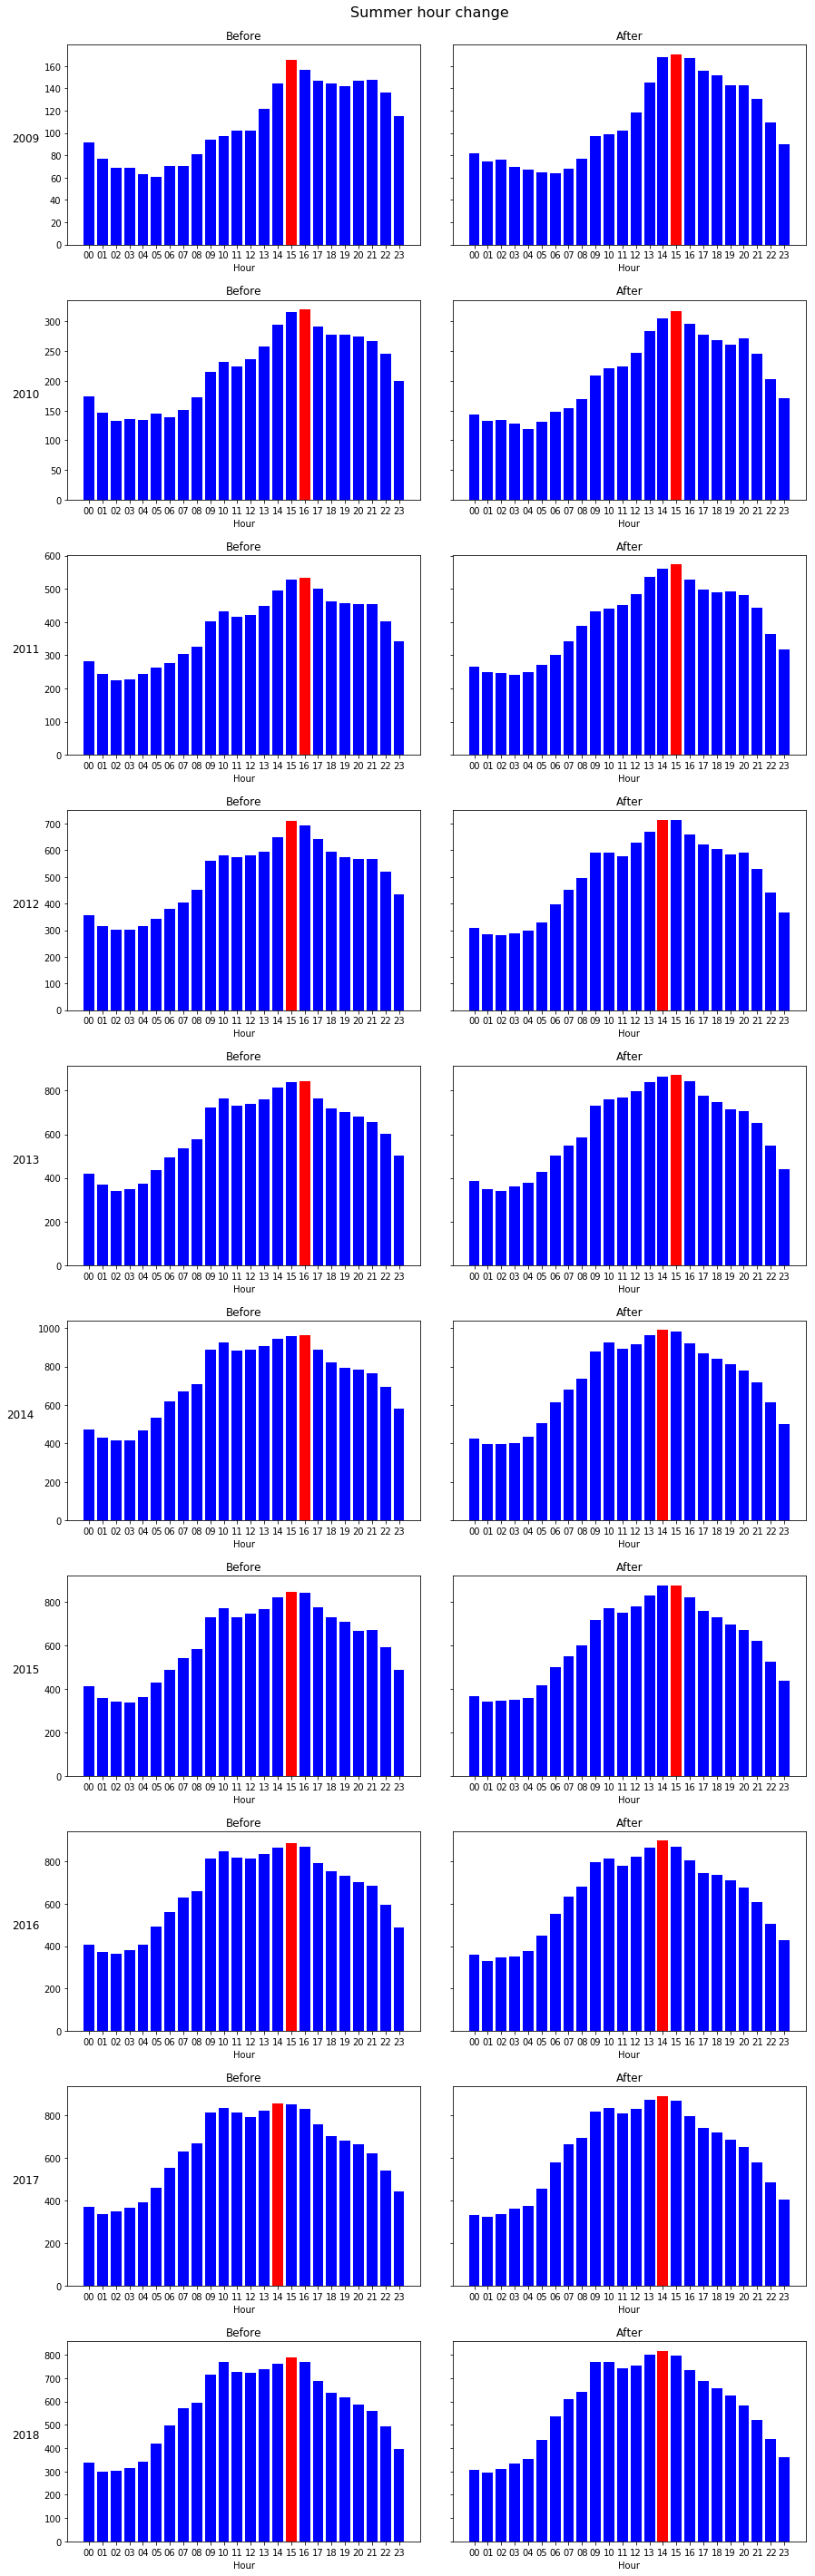

In [10]:
# Plot posts for summer
plot_post_counts(summer_dfs, 'Summer', range(2009, 2019))

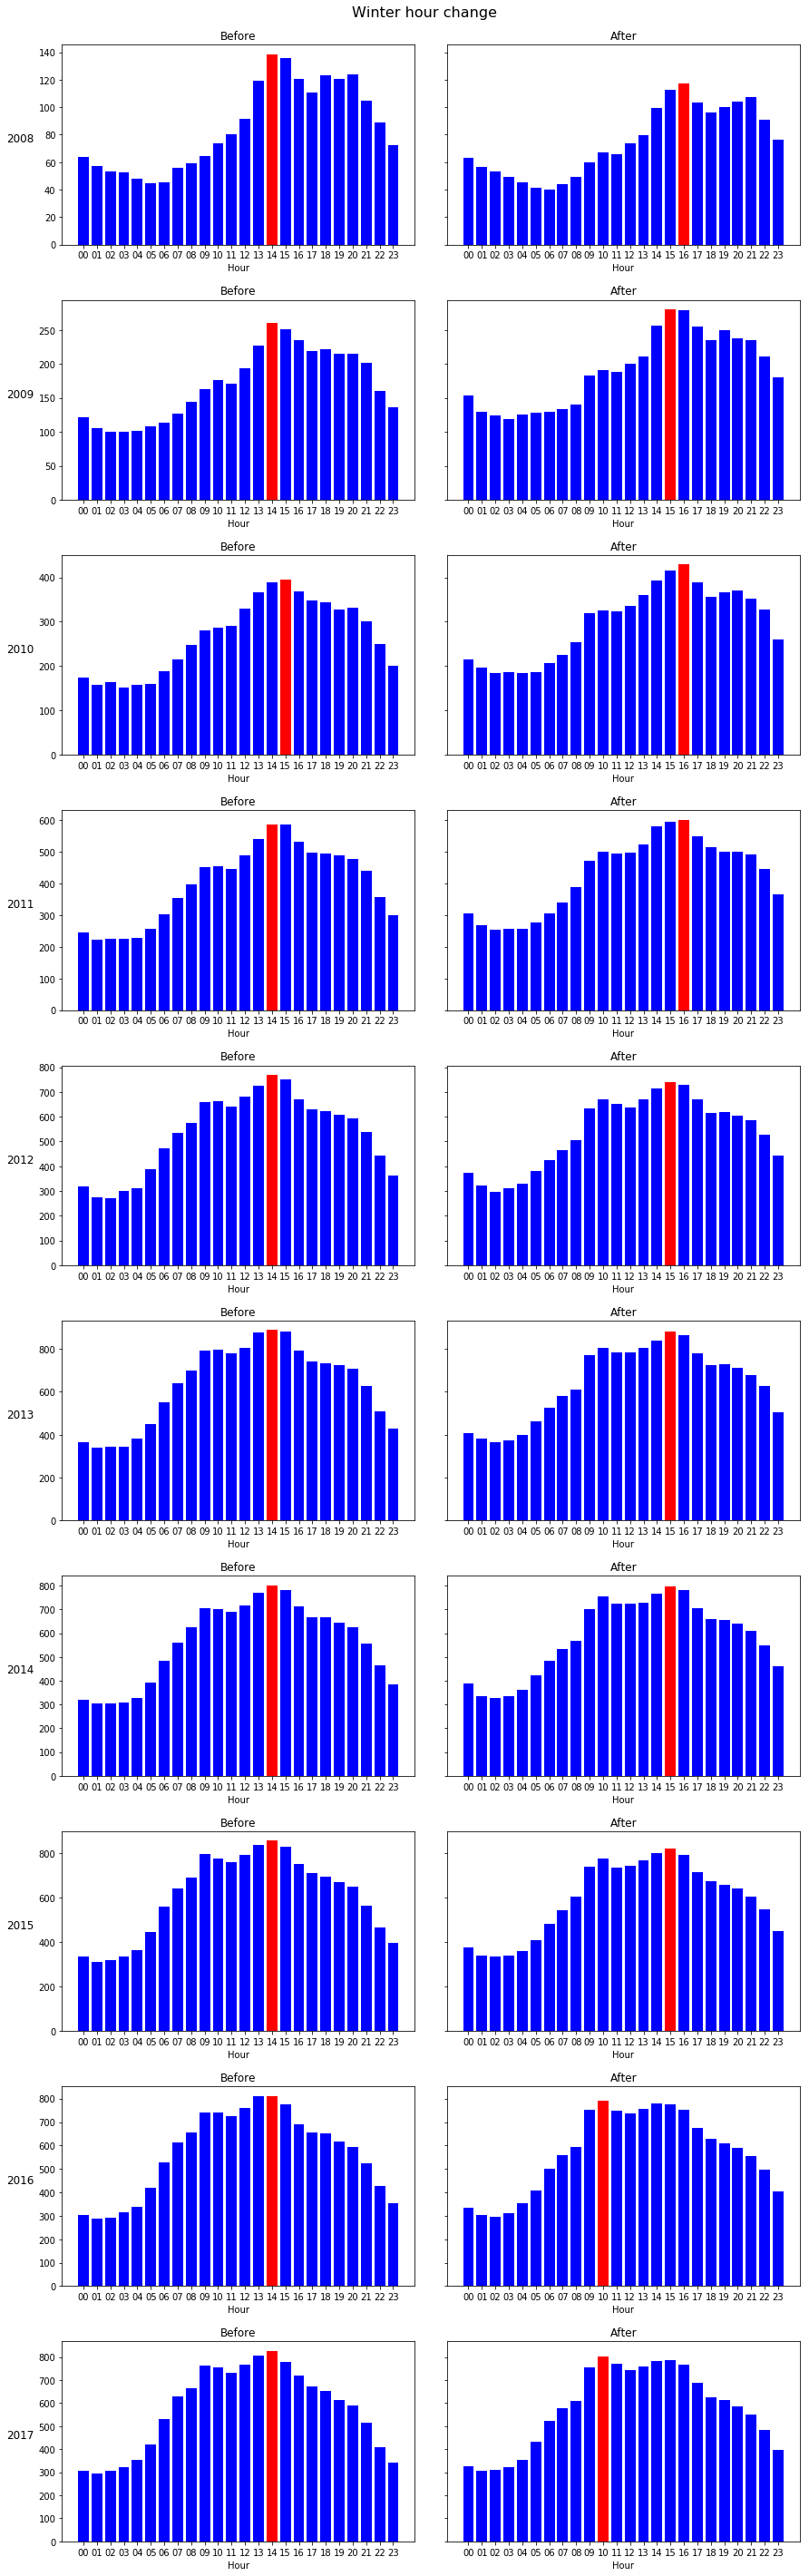

In [11]:
# Plot posts for winter
plot_post_counts(winter_dfs, 'Winter', range(2008, 2018))

We see by looking for the peaks in the number of posts, that usually at a summer hour change the distribution shifts to the left, while at a winter hour change, it shifts to the right. Of course, there are exceptions, especially for the winter hour changes in 2016 and 2017, but there the distribution tends to have two peaks, which is a behavior that we will explain shortly. Considering that US users constitute a large proportion of the Stack Overflow users, this behavior is expectable. We see that peaks normally occur at 2 or 3 pm in the summer time and at 3 or 4 pm in the winter time, just as we would have expected from the hour difference between UTC and US timezones. This corresponds to a normal start of a working day for a programmer.

We also observe the increase in the number of posts over time. It's only normal, as more and more people have access to the internet and are more interested in programming. While in the first years the peak is clear, the distribution also changes a bit over time, as US users decrease in proportion with more and more users from other countries joining the community, which brings the distribution towards a more uniform shape. This may also motivate the 10 am peak in the month after the winter hour changes in 2016 and 2017, a sign that European users may have become just as active as US ones.

#### Propensity score analysis

We now inspect the data more rigurously. As the number of users varies greatly over the years, we can not just aggregate the data for some hour change from all the years, so each hour change will have to be treated independently from the others. We will reduce the samples to some propensity scores, match the data before and after the hour change by these scores and observe if the expected shifts occur.

We start by splitting the data in before and after hour change dataframes.

In [12]:
def split_data(dfs):
    '''
    Split the dataframes in before and after hour change dataframes
    input:  dfs - spark dataframes to be split
    output: dataframes for data before and after hour changes
    '''
    before_dfs, after_dfs = [], []
    for df in dfs:
        df = df.toPandas()
        before_df = df.iloc[:len(df)//2]
        hour_df = pd.DataFrame({'Hour': before_df['Date'].apply(lambda x: int(x.split('T')[1]))})
        before_df = before_df.join(hour_df)
        before_df = before_df.drop(['Date', 'TotalScore'], axis=1)
        before_dfs.append(before_df)
        after_df = df.iloc[len(df)//2:]
        hour_df = pd.DataFrame({'Hour': after_df['Date'].apply(lambda x: int(x.split('T')[1]))})
        after_df = after_df.join(hour_df)
        after_df = after_df.drop(['Date', 'TotalScore'], axis=1)
        after_dfs.append(after_df)
    
    return before_dfs, after_dfs

# Split dataframes
summer_before_dfs, summer_after_dfs = split_data(summer_dfs)
winter_before_dfs, winter_after_dfs = split_data(winter_dfs)

Next up, we compute the propensity scores for each before and after hour change pair.

In [13]:
from sklearn.linear_model import LogisticRegression

def compute_propensity(before_dfs, after_dfs):
    '''
    Compute propensity scores given the two classes, before and after hour change
    input:  before_dfs - dataframes for before hour change period
            after_dfs - dataframes for after hour change period
    output: propensity scores per class
    '''
    preds_before, preds_after = [], []
    for before_df, after_df in zip(before_dfs, after_dfs):
        # Prepare training set
        X = np.concatenate([before_df.values, after_df.values])
        Y = np.array([0] * before_df.shape[0] + [1] * after_df.shape[0])
        # Train logistic regression model
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(X, Y)
        # Compute the propensity scores
        pred = np.apply_along_axis(lambda x: x[1], 1, lr.predict_proba(X))
        pred_before = pred[:before_df.shape[0]]
        preds_before.append(pred_before)
        pred_after = pred[before_df.shape[0]:]
        preds_after.append(pred_after)
    
    return preds_before, preds_after

# Compute the propensity scores for summer and winter dataframes
summer_before_props, summer_after_props = compute_propensity(summer_before_dfs, summer_after_dfs)
winter_before_props, winter_after_props = compute_propensity(winter_before_dfs, winter_after_dfs)

Let's do a quick check of the range of the propensity scores.

In [14]:
def propensity_ranges(before_props, after_props):
    '''
    Compute the ranges of the propensity scores for the given dataframes
    input:  before_props - propensity scores for before the hour change
            after_props - propensity scores for after the hour change
    output: ranges for the given dataframes
    '''
    before_mins, before_maxs, after_mins, after_maxs = [], [], [], []
    for before_prop in before_props:
        before_mins.append(before_prop.min())
        before_maxs.append(before_prop.max())
    for after_prop in after_props:
        after_mins.append(after_prop.min())
        after_maxs.append(after_prop.max())
    # Build dataframe containing the given stats
    df = pd.DataFrame({'before_min': before_mins, 'before_max': before_maxs,
                       'after_min': after_mins, 'after_max': after_maxs})
    return df
    
# Compute the range of propensity scores for the summer and winter hour change
summer_ranges = propensity_ranges(summer_before_props, summer_after_props)
winter_ranges = propensity_ranges(winter_before_props, winter_after_props)

print('Summer')
display(summer_ranges)
print('Winter')
display(winter_ranges)

Summer


,after_max,after_min,before_max,before_min
0,0.512090,0.493570,0.511599,0.492439
1,0.560300,0.427946,0.555125,0.433163
2,0.602683,0.410806,0.594197,0.414118
3,0.500866,0.498888,0.500793,0.498657
4,0.513594,0.484870,0.513330,0.485859
5,0.518775,0.480506,0.527247,0.481919
6,0.503232,0.496920,0.503365,0.496994
7,0.553949,0.440330,0.550412,0.447713
8,0.501388,0.498640,0.501268,0.498574
9,0.515683,0.485635,0.514139,0.485835


Winter


,after_max,after_min,before_max,before_min
0,0.651114,0.312179,0.641036,0.265597
1,0.715982,0.356387,0.688044,0.338271
2,0.673293,0.353456,0.664656,0.320485
3,0.609865,0.405962,0.607295,0.399044
4,0.509592,0.490845,0.509749,0.489362
5,0.512008,0.488142,0.513142,0.486522
6,0.550532,0.456796,0.552888,0.439671
7,0.518333,0.481063,0.519852,0.480045
8,0.506508,0.494482,0.506419,0.494304
9,0.507695,0.493200,0.508002,0.492735


We see that in general the scores are not very widely distributed, being concentrated at the neutral value of, especially for more recent years. This may result in meaningless matches, meaning that we might not get an informative result from this kind of analysis.

Now, we need to match the items from the before dataframe with the ones for the after dataframe, for each of the dataframe pairs.

In [15]:
def match(before_props, after_props):
    '''
    Match items in two datasets based on their propensity scores
    input:  before_props - propensity scores for dataframes before hour change
            after_props - propensity scores for dataframes after hour change
    output: matching between the two types of dataframes for each such pair
    '''
    matchings = []
    for before_prop, after_prop in zip(before_props, after_props):
        # Compute cost matrix for matching
        mat_before = np.repeat(before_prop.reshape(-1,1), len(after_prop), axis=1)
        mat_after = np.repeat(after_prop.reshape(1,-1), len(before_prop), axis=0)
        cost_mat = np.abs(mat_after - mat_before)
        # Make greedy matching
        matching = []
        check_val = np.max(cost_mat) + 1
        max_iter = np.min(cost_mat.shape)
        for i in range(max_iter):
            min_pos = np.argmin(cost_mat)
            min_row = min_pos // cost_mat.shape[1]
            min_col = min_pos % cost_mat.shape[1]
            matching.append((min_row, min_col))
            cost_mat[min_row, :] = check_val
            cost_mat[:, min_col] = check_val
        matchings.append(matching)
    
    return matchings

# Compute matchings for summer and winter dataframes
summer_match = match(summer_before_props, summer_after_props)
winter_match = match(winter_before_props, winter_after_props)

Now that we have the matchings, we can find the relationship between the hour covariate for each of the matched pairs and this will show us if there are shifts or not in the posts distributions.

In [16]:
def hour_difference_count(before_dfs, after_dfs, matchings):
    '''
    Generate dataframes with counts for hour differences registered between matched before and after items
    input:  before_dfs - dataframes for before hour change
            after_dfs - dataframes for after hour change
            matchings - matched items from before and after dataframe pairs
    output: dataframes containing the counts for hour differeces between matched before and after items
    '''
    hour_dfs = []
    for (before_df, after_df, match) in zip(before_dfs, after_dfs, matchings):
        # Generate dataframe with hour differences between matched samples
        hour_diffs = []
        for m in match:
            diff = after_df['Hour'].iloc[m[1]] - before_df['Hour'].iloc[m[0]]
            if diff < -12:
                diff += 24
            elif diff > 12:
                diff -= 12
            hour_diffs.append(diff)
        hour_df = pd.DataFrame({'hour_diff': hour_diffs})
        hour_dfs.append(hour_df)

    return hour_dfs
    
# Generate hour differences for summer and winter dataframes
summer_hour_diffs = hour_difference_count(summer_before_dfs, summer_after_dfs, summer_match)
winter_hour_diffs = hour_difference_count(winter_before_dfs, winter_after_dfs, winter_match)

Summer


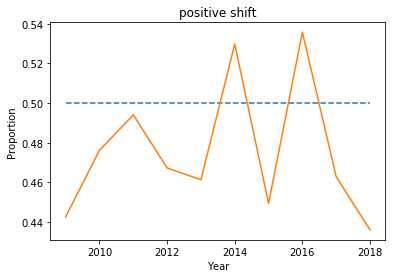

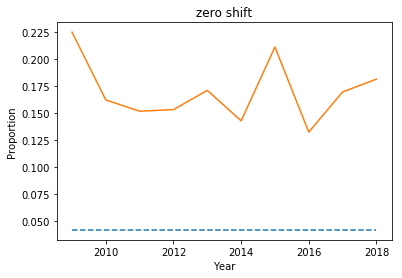

Winter


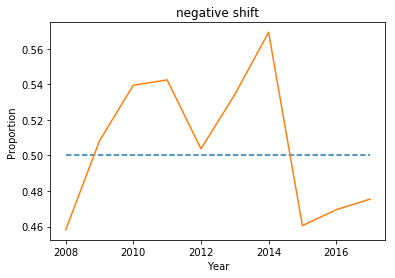

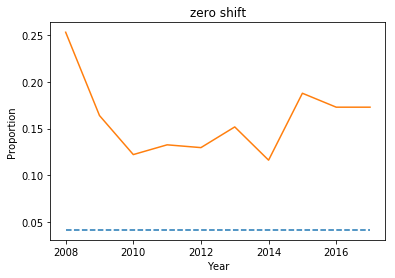

In [17]:
def plot_shifts(hour_diffs, years, shift_type='positive'):
    '''
    Plot hour positive/negative and zero shifts for the given hour difference counts
    input:  hour_diffs - hour difference counts
            years - years for the given dataframes
            shift_type - what kind of shift to plot
    '''
    sign_shifts = []
    zero_shifts = []
    for hour_diff in hour_diffs:
        hour_agg_df = hour_diff.groupby(['hour_diff']).size().reset_index(name='count')
        sign = hour_agg_df[hour_agg_df['hour_diff'] > 0]['count'].sum()
        sign_shifts.append(sign / hour_agg_df['count'].sum())
        zero = hour_agg_df[hour_agg_df['hour_diff'] == 0]['count'].sum()
        zero_shifts.append(zero / hour_agg_df['count'].sum())
    # Plot the signed shift
    plt.figure()
    plt.plot(years, [0.5] * len(years), linestyle='dashed')
    plt.plot(years, sign_shifts)
    plt.title(f'{shift_type} shift')
    plt.ylabel('Proportion')
    plt.xlabel('Year')
    plt.show()
    # Plot the zero shift
    plt.figure()
    plt.plot(years, [1/24] * len(years), linestyle='dashed')
    plt.plot(years, zero_shifts)
    plt.title('zero shift')
    plt.ylabel('Proportion')
    plt.xlabel('Year')
    plt.show()

# Plot the proportion of positive and zero shifts for summer and negative and zero shifts for winter
print('Summer')
plot_shifts(summer_hour_diffs, list(range(2009, 2019)), 'positive')
print('Winter')
plot_shifts(winter_hour_diffs, list(range(2008, 2018)), 'negative')

We see from the plots that there is no clear shift for the matchings that we've done. However, there is a considerable proportion of no shift cases for both summer and winter, which may indicate that the hour change has no effect.

We have already mentioned that the propensity scores are mainly concentrated around 0.5, leading to a pretty random matching. We thus change our focus to a simpler analysis model, namely we will look at the 50% quantiles for the post counts before and after the hour change.

#### Quantile analysis
We extract the 50% quantile for each before and after hour change pair of dataframes and compare these in hope of noticing a shift. This is a robust statistic, so it is fine to use it even in case some outliers may occur.

In [18]:
def quantile(df, q):
    '''
    Compute the q-quantile for the posts count of a dataframe
    input:  df - dataframe of post counts to analyze
            q - the quantile to return
    output: the q-quantile for the posts distribution
    '''
    counts = df['PostsCount']
    # Compute the cumulative distribution of the counts
    cdf = [counts.iloc[0]]
    for i in range(1, counts.shape[0]):
        val = cdf[-1] + counts.iloc[i]
        cdf.append(val)
    # Compute the value associated to the quantile
    prop = q * cdf[-1]
    # Find the quantile
    for i in range(len(cdf)):
        if prop <= cdf[i]:
            return i
    return -1

# Compute the 50% quantile for the before and after hour change dataframes
summer_before_qs = [quantile(df.groupby('Hour').sum(), 0.5) for df in summer_before_dfs]
summer_after_qs = [quantile(df.groupby('Hour').sum(), 0.5) for df in summer_after_dfs]
winter_before_qs = [quantile(df.groupby('Hour').sum(), 0.5) for df in winter_before_dfs]
winter_after_qs = [quantile(df.groupby('Hour').sum(), 0.5) for df in winter_after_dfs]

Now, let's examine quantiles for summer and winter hour change.

In [19]:
print("Summer hour change")
print("Before:", summer_before_qs)
print("After:", summer_after_qs)
print("Winter hour change")
print("Before:", winter_before_qs)
print("After:", winter_after_qs)

Summer hour change
Before: [14, 14, 14, 13, 13, 13, 13, 13, 13, 13]
After: [14, 14, 13, 13, 13, 13, 13, 13, 13, 13]
Winter hour change
Before: [14, 14, 14, 13, 13, 13, 13, 13, 13, 13]
After: [15, 14, 14, 14, 13, 13, 13, 13, 13, 13]


We see that except for two isolated cases, the 50% quantile remains the same for before and after the hour change, both in summer and in winter.

Despite the initial visual intuition, we conclude that for the Stack Overflow dataset we can not find a clear effect of the hour change on the posts distribution.

### 2. Which hour change has the greatest impact?

Considering that in the previous section we concluded that we could not see an impact of the hour change on the posts distribution, we can not say that the summer or the winter hour change has a greater impact than the other on the posts distribution. We could however take a look at how each hour change affects the scores around that period.

We will choose to look at two days before and two days after the hour changes occur, as in a wider window the statistics for the after hour change time slot may stabilize and become similar to the ones in the before hour change time slot.

In [20]:
def get_scores_by_hour(dfs):
    '''
    Split each of the dataframes in half and aggregate scores by hour for each half
    input:  dfs - spark dataframes to get the scores from
    output: two dataframes containing scores by hour before and after hour change
    '''
    score_before_dfs, score_after_dfs = [], []
    for df in dfs:
        # Split the dataframe
        df = df.toPandas()
        df['Hour'] = df['Date'].apply(lambda x: x.split('T')[1])
        before_df = df[:len(df)//2]
        after_df = df[len(df)//2:]
        # Get total scores by hour
        score_before_df = before_df.groupby('Hour').sum()
        score_before_dfs.append(score_before_df)
        score_after_df = after_df.groupby('Hour').sum()
        score_after_dfs.append(score_after_df)
    
    return score_before_dfs, score_after_dfs

# Get data for a window of 4 days around each hour change
summer_dfs, winter_dfs = hour_change_stats(summer_change, winter_change, 2)

# Get total score by hour before and after hour change
summer_before_scores, summer_after_scores = get_scores_by_hour(summer_dfs)
winter_before_scores, winter_after_scores = get_scores_by_hour(winter_dfs)

We'll plot the difference in total score for each hour change from each year.

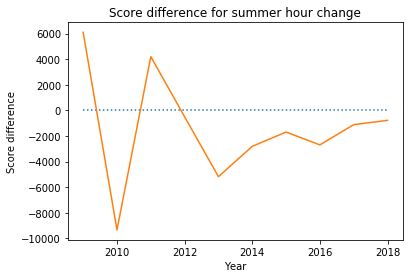

Score differences are distributed over the years with mean -1376.8 and standard deviation 4123.243839503068


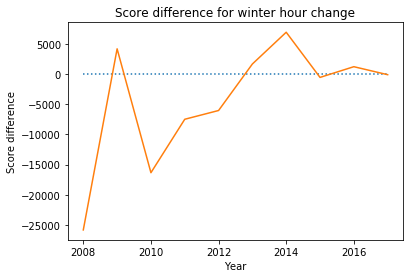

Score differences are distributed over the years with mean -4235.0 and standard deviation 9576.602257585933


In [21]:
def plot_score_differences(before_scores, after_scores, years, season):
    '''
    Plot the score difference between before and after dataframe pairs
    input:  before_scores - dataframes for before hour change
            after_scores - dataframes for after hour change
            years - what years the data is from
            season - summer of winter
    '''    
    # Compute score differences
    score_diffs = []
    for (before, after) in zip(before_scores, after_scores):
        before_score = before['TotalScore'].sum()
        after_score = after['TotalScore'].sum()
        score_diffs.append(after_score - before_score)
    score_diffs = np.array(score_diffs)
    
    # Plot the score differences
    plt.figure()
    plt.title(f'Score difference for {season} hour change')
    plt.xlabel('Year')
    plt.ylabel('Score difference')
    plt.plot(years, [0] * len(years), linestyle='dotted')
    plt.plot(years, score_diffs)
    plt.show()
    
    # Display mean and std
    mean, std = score_diffs.mean(), score_diffs.std()
    print(f'Score differences are distributed over the years with mean {mean} and standard deviation {std}')


# Plot the score differences for summer and winter hour changes
plot_score_differences(summer_before_scores, summer_after_scores, list(range(2009, 2019)), 'summer')
plot_score_differences(winter_before_scores, winter_after_scores, list(range(2008, 2018)), 'winter')

We see that both for the summer and the winter hour changes the score has a higher mean before the hour change over the years. However, in both cases the standard deviation is very large, so we can not say clearly that the hour change affects the scores.

We could note though that the winter hour change presents a bigger mean difference in absolute value and a larger variance, which points to a larger impact of the winter hour change than the summer hour change.

# Wikipedia Data

We generated a dataset based on the Wikipedia data to complete our analysis with a validation with another data source.
To obtain this data, we wrote a simple Python script, which makes use of the Wikipedia API (https://www.mediawiki.org/wiki/API:Recent_changes_stream).

Wikipedia only allow their users to get the last 30 days changes. Relative to the moment we finished writing the script, we chose a period of 31 days, from 2018-10-18 13:38:21 to 2018-11-17 00:00:15, in other words, 17 days before the hour change and 13 days after.

This time window is relevant for our problem, because we need to analyze a long-period behavior evolution of users.

The number of changes per second in Wikipedia is large. That's why we had to limit the number of changes we got (31 days of changes represent  approximately 560 GB of data).

We got the 100th first changes each 15 minutes for our time period to limit the amount of data to be stored.

Because of this choice, we can't compare the number of changes before and after the hour change. We have to find others indicators to validate our theories.

### Wikipedia changes API request format

A sample API request looks like this:
https://en.wikipedia.org/w/api.php?action=query&format=json&list=recentchanges&rcprop=ids%7Csizes%7Cfrcshow=!bot%7Clags%7Cuserid%7Ctimestamp&rclimit=100&rcstart='+wikistamp+'&rcdir=newer

The parameters used for the API requests have the following role:
- rcprop: which parameters to keep from the API response (here: id, size, exclude bot changes, userid, timestamp)
- rclimit: how many changes to get for each request (here: 100 per request)
- rcstart: the timestamp to start listing from (here: we put an iterator and add 15 minutes after each iteration)
- rcdir: direction to list in (newer/older)
- wikistamp: Python variable to increment timestamp call

### Dataset Analysis

Having collected the dataset, we can now begin to analyse it.

In [22]:
# Load the wikipedia dataset
DATA = './data/wikiData.json'
wiki_df = spark.read.json(DATA)
wiki_df.printSchema()

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)



In [23]:
# Save the data in parquet format for faster loading afterwards
wiki_df.write.parquet("posts.parquet")

In [24]:
# Given the reasonable size of the data, transform it into a Pandas dataframe
df = wiki_df.toPandas()
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['timestamp'])
df.head()

,actionhidden,anon,newlen,old_revid,oldlen,pageid,rcid,revid,suppressed,timestamp,type,userhidden,userid
0,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
1003,None,None,0,0.0,0,58801096.0,1097276477,864631664.0,None,2018-10-18 13:38:21,categorize,None,31946894.0
1002,None,None,210,0.0,0,58801096.0,1097276476,864631664.0,None,2018-10-18 13:38:21,new,None,31946894.0
1001,None,,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,None,2018-10-18 13:38:21,edit,None,0.0
1000,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0


We can delete the *actionhidden* (title is hidden or not) and *anon* (user is logged in or not) parameters. We also keep *userid* and remove *userhidden* (user is hidden or not), because if the userid is 0, we already knoe the user is hidden. The *suppressed* parameter can be deleted too, because it's just a boolean which is true when more details about the suppression is available and it's not useful for our analysis.

In [25]:
df = df.drop(['anon','actionhidden','suppressed','userhidden'],axis=1)
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,categorize,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,new,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,edit,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0


We will now assign a numerical value to the different string values contained in type, in order to be able to correlate them with the other values.

In [26]:
df.type.unique()

array(['edit', 'categorize', 'new', 'log'], dtype=object)

To refer to wikipedia API : 
- edit: Regular page edits
- new: Page creations (Uploads are not listed as new but as log)
- log: Log entries
- categorize: Page categorizations

We will use the convention:
- edit = 0
- categorize = 1
- new = 2
- log = 3

In [27]:
# Map type values to ids
type_id = {'edit': 0, 'categorize': 1, 'new': 2, 'log': 3}

df.type = df.type.map(lambda x: type_id[x])
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0


We can find the number of changes with newlen and oldlen.

In [28]:
df['lenchanged'] = df['newlen'] - df['oldlen']
df = df.drop(['newlen','oldlen'],axis=1)
df.head()

,old_revid,pageid,rcid,revid,timestamp,type,userid,lenchanged
0,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
1003,0.0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0,0
1002,0.0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0,210
1001,849115441.0,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0,-15
1000,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24


In [29]:
# Display fist and last entries' dates
print(f'First change dates back to {df.timestamp.values[0]}')
print(f'Last change dates back to {df.timestamp.values[-1]}')

First change dates back to 2018-10-18T13:38:21.000000000
Last change dates back to 2018-11-17T00:00:15.000000000


In [30]:
# Split dataframe in 'before' and 'after' hour change
change_hour = datetime.utcfromtimestamp(1541293200).strftime('%Y-%m-%dT%H:%M:%SZ')
before_df = df.loc[df['timestamp'] < change_hour]
after_df = df.loc[df['timestamp'] > change_hour]

#### Correlation

Let's take a look at the correlation between the data fields that we have.

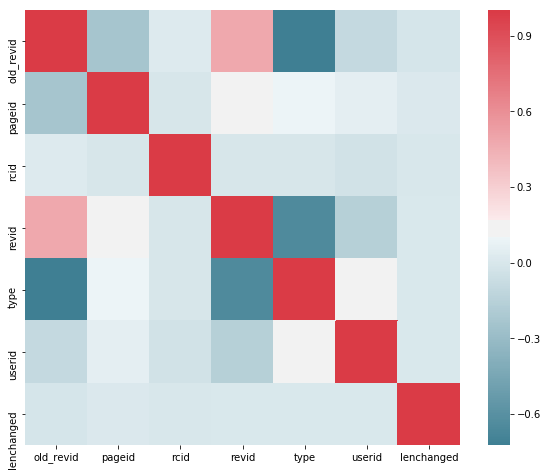

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
_ = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The matrix shows us a correlation between old and new revision ids, explained by the fact the two numbers are always of the same order of magnitude.

Now, let's take a look at how the types of changes are distributed before and after the hour change.

,type,count
0,edit,100830
1,categorize,50495
2,log,7006
3,new,6069


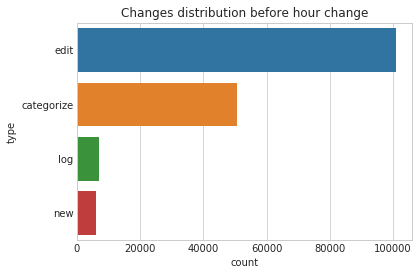

In [32]:
# Distribution of the change type before the hour change
id_to_type = {0: 'edit', 1: 'categorize', 2: 'new', 3: 'log'}
before_categories_df = before_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
before_categories_df.reset_index(level=0, inplace=True)
before_categories_df.type = before_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=before_categories_df).set_title('Changes distribution before hour change')
display(before_categories_df)

,type,count
0,edit,76935
1,categorize,37701
2,log,5805
3,new,4057


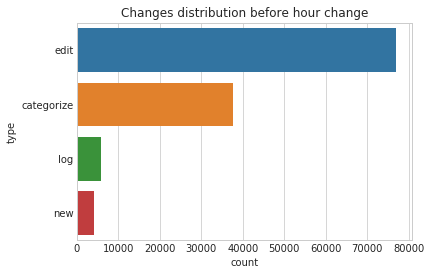

In [33]:
# Distribution of the change type after the hour change
after_categories_df = after_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
after_categories_df.reset_index(level=0, inplace=True)
after_categories_df.type = after_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=after_categories_df).set_title('Changes distribution before hour change')
display(after_categories_df)

In [34]:
# Check the proportions between the counts before and after the hour change for each category
proportions = after_categories_df['count'] / before_categories_df['count']
prop_df = pd.DataFrame({'type': ['edit', 'categorize', 'log', 'new'], 'proportion': proportions})
display(prop_df)

,proportion,type
0,0.763017,edit
1,0.746628,categorize
2,0.828576,log
3,0.668479,new


The distribution of each category seem similar, the difference in numbers being due to the fact that there are more days before than after DST. We could just note that there seems to be a slightly bigger proportion of logs and a smaller proportion of new articles, but the differences are not numerically considerable.

#### Number of Lines

Let's see if there's some modification into the number of lines changed.

In [35]:
# Consider the absolute value in the number of lines changed
edit_before = before_df.loc[before_df['type'] == 0].copy()
edit_before.loc[:, 'lenchanged'] = edit_before.lenchanged.abs()

print('Line change statistics before hour change')
edit_before.lenchanged.describe()

Line change statistics before hour change


count    1.008300e+05
mean     4.196499e+02
std      6.661732e+03
min      0.000000e+00
25%      7.000000e+00
50%      3.700000e+01
75%      1.600000e+02
max      1.115864e+06
Name: lenchanged, dtype: float64

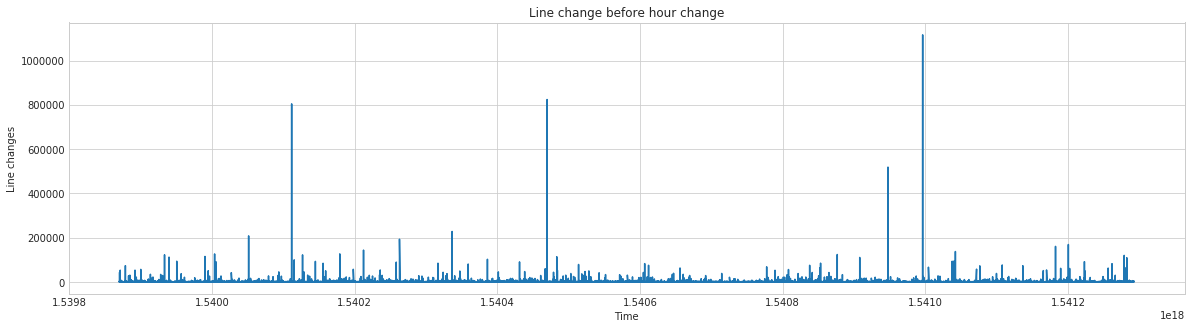

In [36]:
xb = edit_before['timestamp']
yb = edit_before['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xb, yb)
plt.title('Line change before hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

In [37]:
# Consider the absolute value in the number of lines changed
edit_after = after_df.loc[after_df['type'] == 0].copy()
edit_after.lenchanged = edit_after.lenchanged.abs()

print('Line change statistics after hour change')
edit_after.lenchanged.describe()

Line change statistics after hour change


count     76935.000000
mean        509.104400
std        9129.504627
min           0.000000
25%           7.000000
50%          37.000000
75%         173.000000
max      962125.000000
Name: lenchanged, dtype: float64

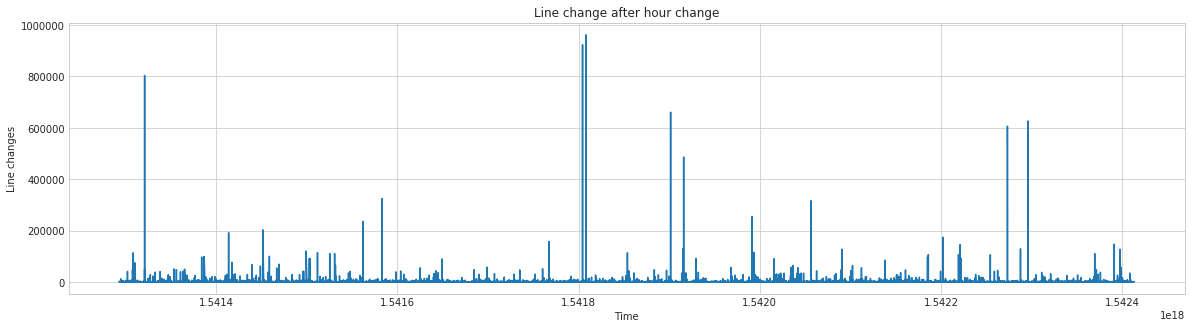

In [38]:
xa = edit_after['timestamp']
ya = edit_after['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xa, ya)
plt.title('Line change after hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

Analysing visually, we can see that number of peaks in the edits done after the hour change is higher than for the period before the hour change.

### Summary

#### Data Handle
The dataset that we collected is quite small (53MB), therefore we don't need to make use of Spark in order to handle it.

In what comes next, we plan to collect more data, so that we can better understand the behaviour evolution before and after the hour change.

#### Understanding the Data
After cleaning and formatting our data to achieve the best possible interpretation, we began to analyze it.
Despite some correlation with no real causality, we have been able to better understand which analysis we should focus on: the dataset is relatively small and the features obtained do not carry a lot of information, we will focus on the activity of people through the amount of data modified before and after the time change.

#### Transform the Data
To improve the accuracy of our work, users' data can be cross-referenced to get their geographic coordinates and get a more accurate idea of the effects of time changes on specific geographic areas.

#### Methodology
Getting a complete analysis with only this dataset is impossible considering its size. This is why it will serve as a validation set for the analysis that we will perform in the data that we are going to collect.
We will therefore split this dataset in a short time interval in order to perform an analysis of the activity on the type of changes of the articles and on the amount of information modified, around the date of the hour change.

### Larger dataset follow-up

In what comes next, we decided to collect a larger dataset comprising all the changes done in the week before and the week after the winter hour change for this year. For this, we once again used the Wikipedia API described above to collect a total of 595 MB of data. Due to the size of the new dataset, we will make use of Spark this time.

In [39]:
# Load the data
EXTENDED_DATA = "./data/wikiExtendedData.json"
wiki_df = spark.read.json(EXTENDED_DATA)

In [40]:
# Inspect the data format
wiki_df.printSchema()
wiki_df.show(10)

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)

+------------+----+------+---------+------+-------+----------+---------+----------+--------------------+----------+----------+--------+
|actionhidden|anon|newlen|old_revid|oldlen| pageid|      rcid|    revid|suppressed|           timestamp|      type|userhidden|  userid|
+------------+----+------+---------+------+-------+----------+---------+----------+--------------------+----------+----------+--------+
|        null|null|  1231|752810129|  1163|8995512|1100026980|866209155|      null|2018-10-29

In [41]:
# Register view to do SQL queries
wiki_df.createOrReplaceTempView("Wiki")

In [42]:
posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
            DATE_FORMAT(timestamp, "yyyy-MM-dd'T'HH") as Date
            FROM Wiki
            GROUP BY Date
            ORDER BY Date ASC""")

posts_date.show(10)

+----------+-------------+
|PostsCount|         Date|
+----------+-------------+
|     10145|2018-10-29T01|
|     10620|2018-10-29T02|
|      9539|2018-10-29T03|
|     10640|2018-10-29T04|
|      7778|2018-10-29T05|
|      6851|2018-10-29T06|
|      6183|2018-10-29T07|
|      6057|2018-10-29T08|
|      7795|2018-10-29T09|
|      6912|2018-10-29T10|
+----------+-------------+
only showing top 10 rows



In [43]:
posts_date_df = posts_date.toPandas()
posts_date_df['Hour'] = posts_date_df['Date'].apply(lambda x: x.split('T')[1])

In [44]:
# Split data in before and after the hour change
before_df = posts_date_df[:167]
after_df = posts_date_df[167:]


before_df = before_df.groupby('Hour').mean()
after_df = after_df.groupby('Hour').mean()

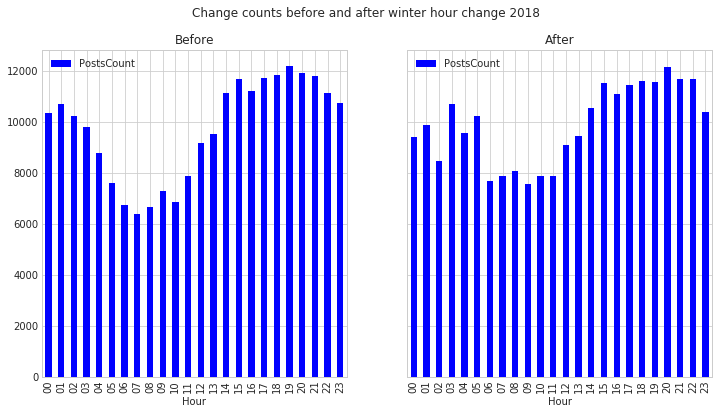

In [45]:
# Plot the count distributions
f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(6)
before_df.groupby('Hour').mean().reset_index().plot.bar(ax=arr[0], x='Hour', y='PostsCount',
                                                        title='Before', color='blue')
_ = after_df.groupby('Hour').mean().reset_index().plot.bar(ax=arr[1], x='Hour', y='PostsCount',
                                                           title='After', color='blue')

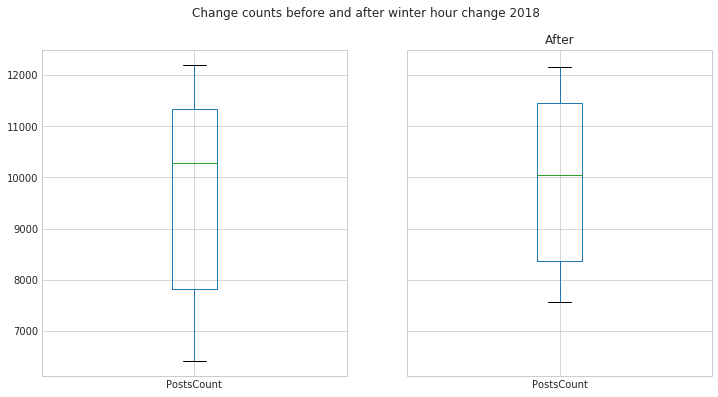

In [46]:
f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(6)
plt.title("Before")
before_df.boxplot(ax=arr[0],column=['PostsCount'])
plt.title("After")
boxplot2 = after_df.boxplot(ax=arr[1],column=['PostsCount'])

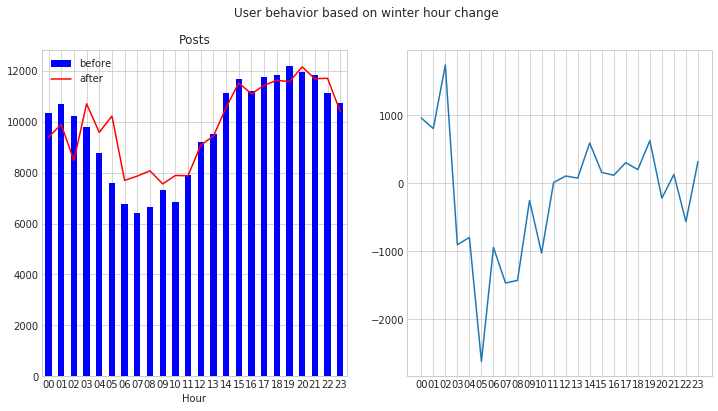

In [47]:
# Plot the count distributions
before = before_df.groupby('Hour').mean().reset_index()
after=after_df.groupby('Hour').mean().reset_index()
before_display = before.rename(columns={'PostsCount':'before'})
after_display = after.rename(columns={'PostsCount':'after'})
f, arr = plt.subplots(1, 2, sharey=False)
f.suptitle(f'User behavior based on winter hour change')
f.set_figwidth(12)
f.set_figheight(6)
before_display.plot.bar(ax=arr[0], x='Hour', y='before', color='blue')
after_display.plot(ax=arr[0], x='Hour', y='after',title='Posts', color='red')
arr[1].plot(before.Hour,before.PostsCount-after.PostsCount)

As expected, we again see a shift of the peak of the distribution towards the right, from 7 pm to 8 pm.

Estimation of Person correlation (based on data before and after an event analysis)

In [48]:
before_series = before_df.PostsCount.values
after_series = after_df.PostsCount.values

before_mean = before_df.PostsCount.mean()
after_mean = after_df.PostsCount.mean()

print(repr(sp.stats.pearsonr(before_series,after_series)))
print(repr(sp.stats.spearmanr(before_series,after_series)))
print("Quantity of changement: " + repr(before_mean/after_mean))

(0.8880198355211755, 7.067452379705058e-09)
SpearmanrResult(correlation=0.8895652173913042, pvalue=6.110896315326465e-09)
Quantity of changement: 0.9830048514057242


In [49]:
shifted_after = after_series[1:]
compared_before = before_series[:-1]
before_mean = compared_before.mean()
after_mean = shifted_after.mean()

print(repr(sp.stats.pearsonr(compared_before,shifted_after)))
print(repr(sp.stats.spearmanr(compared_before,shifted_after)))
print("Quantity of changement: " + repr(before_mean/after_mean))

(0.9117553237192288, 1.434809755679943e-09)
SpearmanrResult(correlation=0.9209486166007905, pvalue=4.710516603350585e-10)
Quantity of changement: 0.9764552884283738


Correlation increase when data shift is reduced & quantity of changement decreased. Two things can be confirmed: the users have "working habits" with more active time slots than others and that the change of time causes a shift of these habits of plus or minus an hour during the week following the time changement. Indeed, after having visually observed that the distributions before and after the time change are similar to an hour, we checked this with mathematics by comparing the correlations and quantities of change before and after the elimination of the hour shift. 

Graphically, we can say "The afternoon activity is less afect by the hour changement than the morning". we'll try to do a similar analysis to prove it.

In [50]:
after_df = after_df.reset_index()
before_df = before_df.reset_index()

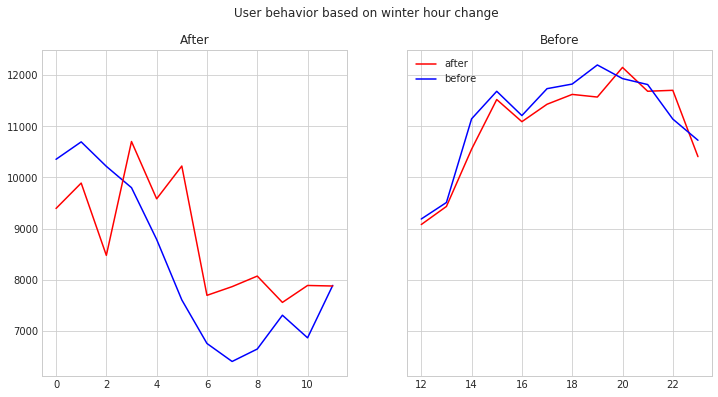

In [51]:
# Morning/afternoon
morning_before= before_df[before_df.Hour < str(12)].PostsCount
morning_after = after_df[after_df.Hour < str(12)].PostsCount
afternoon_before= before_df[before_df.Hour >= str(12)].PostsCount
afternoon_after = after_df[after_df.Hour >= str(12)].PostsCount

f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'User behavior based on winter hour change')
f.set_figwidth(12)
f.set_figheight(6)
morning_before.plot(ax=arr[0], x='Hour', y='PostsCount',title='Before', color='blue',label="before")
morning_after.plot(ax=arr[0], x='Hour', y='PostsCount',title='After', color='red',label="after")

afternoon_after.plot(ax=arr[1], x='Hour', y='PostsCount',title='After', color='red',label="after")
afternoon_before.plot(ax=arr[1], x='Hour', y='PostsCount',title='Before', color='blue',label="before")
plt.legend(loc='upper left')

In [52]:
morning_before_mean = morning_before.values.mean()
morning_after_mean = morning_after.values.mean()

print(repr(sp.stats.pearsonr(morning_before.values,morning_after.values)))
print(repr(sp.stats.spearmanr(morning_before.values,morning_after.values)))
print("Quantity of changement: " + repr(morning_before_mean/morning_after_mean))

(0.6594327219072328, 0.019655661115709638)
SpearmanrResult(correlation=0.6363636363636365, pvalue=0.026096891052703127)
Quantity of changement: 0.9439072722350512


In [53]:
afternoon_before_mean = afternoon_before.values.mean()
afternoon_after_mean = afternoon_after.values.mean()

print(repr(sp.stats.pearsonr(afternoon_before.values,afternoon_after.values)))
print(repr(sp.stats.spearmanr(afternoon_before.values,afternoon_after.values)))
print("Quantity of changement: " + repr(afternoon_before_mean/afternoon_after_mean))

(0.9438058787014338, 4.014112194619272e-06)
SpearmanrResult(correlation=0.7412587412587414, pvalue=0.005801150474478243)
Quantity of changement: 1.014109078810348


As we can see with our indicators, the correlation between afternoon before and after hour changement is high and the quantity of changement is close to 1, so there's no changement. For the morning, there's more divergence as we expected.
Now, we'll try to determinated how many days need people to absorb this shift. We'll analyse days after the hour changement

In [54]:
before = before_df.groupby('Hour').mean().reset_index()
after_df = posts_date_df[167:]

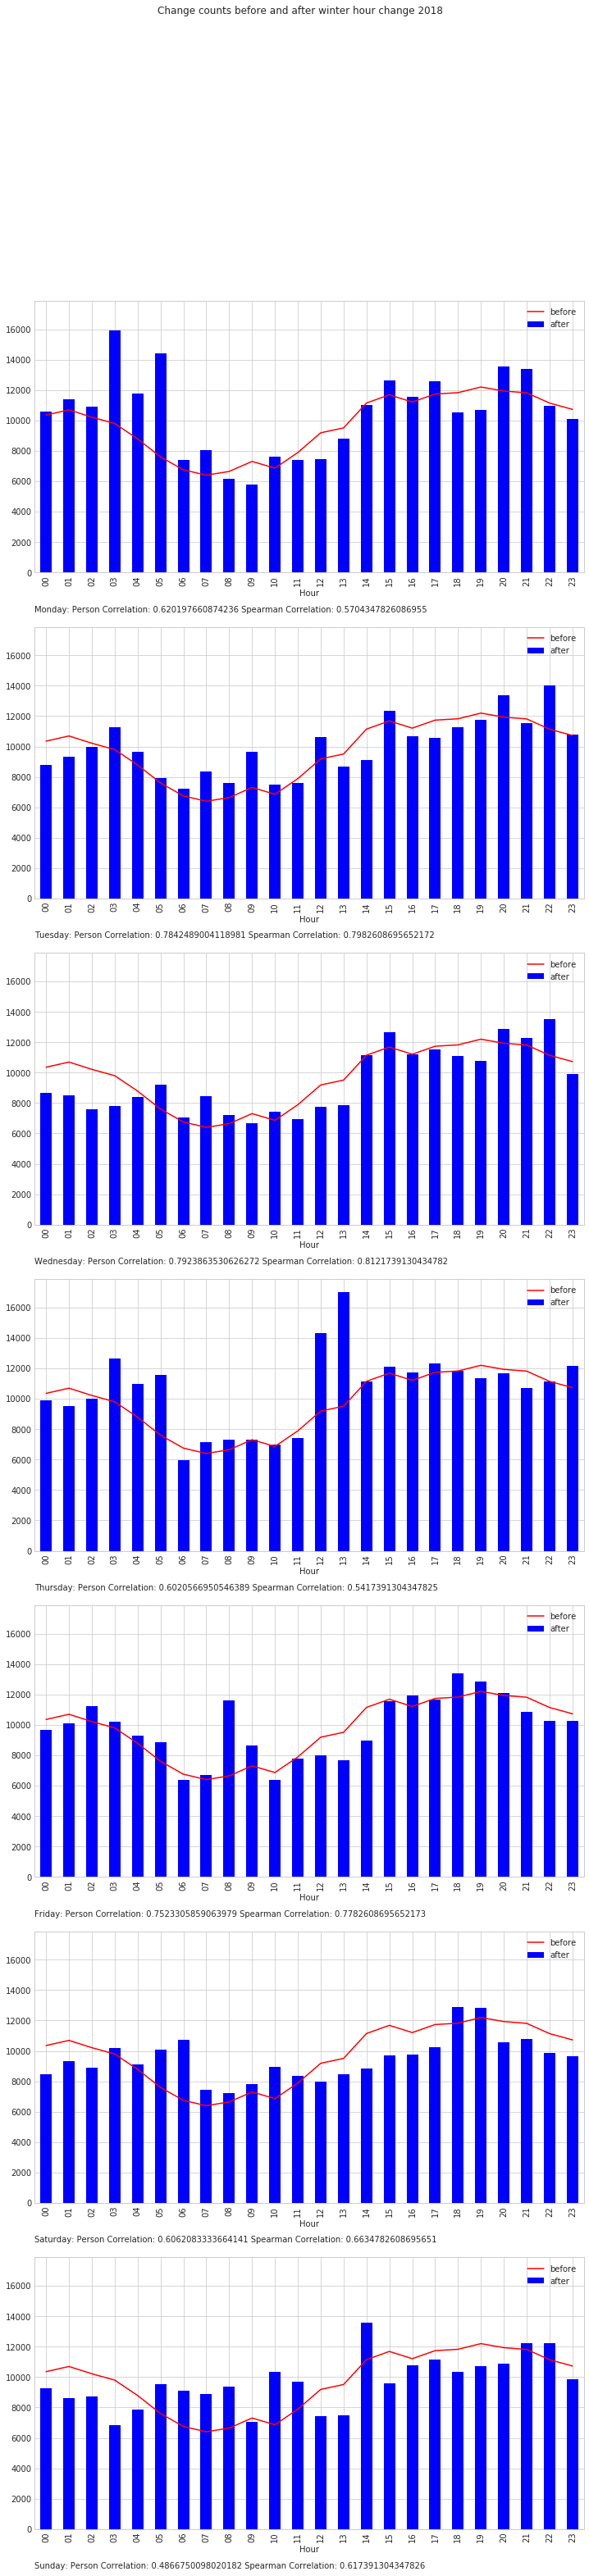

In [55]:
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
correlation = []
f, arr = plt.subplots(7, 1, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(50)
for i in range(7):
    #before = before_df.iloc[i*24:i*24+24]
    after = after_df.iloc[i*24:i*24+24]
    pearson,pv = sp.stats.pearsonr(before.PostsCount.values,after.PostsCount.values)
    spearman,pv = sp.stats.spearmanr(before.PostsCount.values,after.PostsCount.values)
    correlation.append((pearson,spearman))
    pt1=before.plot(ax=arr[i], x='Hour', y='PostsCount', color='red',label="before")
    pt2=after.reset_index().plot.bar(ax=arr[i], x='Hour', y='PostsCount', color='blue',label="after")
    pt2.annotate(days[i]+": Person Correlation: "+repr(pearson)+" Spearman Correlation: "+repr(spearman), (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

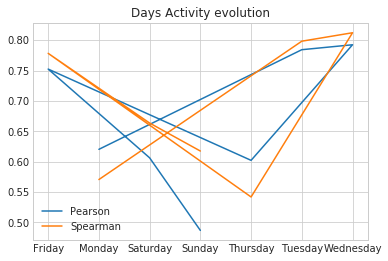

In [56]:
plt.plot(days,correlation)
plt.title("Days Activity evolution")
_ = plt.legend(["Pearson","Spearman"])

# DST Impact on the way people work out

## Description
The dataset consists of 26,000 people counts (about every 10 minutes) over the last year. In addition, it include extra info including weather and semester-specific information that might affect how crowded it is.

Features:
* __date__ (string; datetime of data)
* __timestamp__ (int; number of seconds since beginning of day)
* __day_of_week__ (int; 0 [monday] - 6 [sunday])
* __is_weekend__ (int; 0 or 1) [boolean, if 1, it's either saturday or sunday, otherwise 0]
* __is_holiday__ (int; 0 or 1) [boolean, if 1 it's a federal holiday, 0 otherwise]
* __temperature__ (float; degrees fahrenheit)
* __is_start_of_semester__ (int; 0 or 1) [boolean, if 1 it's the beginning of a school semester, 0 otherwise]
* __month__ (int; 1 [jan] - 12 [dec])
* __hour__ (int; 0 - 23)

In [58]:
DATA_DIR = 'data'
traffic_data = pd.read_csv(os.path.join(DATA_DIR, 'gymData.csv'))
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [59]:
print(traffic_data['date'].describe())
print("\nFirst date: " + traffic_data['date'].min())
print("Last date: " + traffic_data['date'].max())

count                         62184
unique                        62184
top       2015-11-09 14:20:12-08:00
freq                              1
Name: date, dtype: object

First date: 2015-08-14 17:00:11-07:00
Last date: 2017-03-18 19:22:51-07:00


### Time Changes in Los Angeles Over the Years
#### Daylight Saving Time (DST) changes do not necessarily occur on the same date every year.

| Year | Date & Time | Abbreviation | Time Change | Offset After |
|------|-------------|--------------|-------------|--------------|
| 2015 | Sun, 8 Mar, 02:00  | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2015 | Sun, 1 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2016 | Sun, 13 Mar, 02:00 | PST → PDT	| +1 hour (DST start) | UTC-7h |
| 2016 | Sun, 6 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2017 | Sun, 12 Mar, 02:00 | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2017 | Sun, 5 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |

Seems like we have the all of the DST changes except the first and the last one. Let's split our data set to reflect these disjoint periods.

First, we will convert the date to UTC (for convenience, later)

In [60]:
traffic_data['date_utc'] = pd.to_datetime(traffic_data['date'], infer_datetime_format=True)
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,date_utc
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17,2015-08-15 00:00:11
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17,2015-08-15 00:20:14
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17,2015-08-15 00:30:15
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17,2015-08-15 00:40:16
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17,2015-08-15 00:50:17


Second, since we see that the data contains information about the timezone, and the timezone changes as part of the DST change, we can take advantage of this. Basically we split our data set based on continous sequences that have the same timezone offset.

In [61]:
diff = np.diff(traffic_data['date'].str.contains("-07:00"))
ind_split = np.where(diff == True)[0]
traffic_periods = [
    traffic_data.iloc[:ind_split[0]],
    traffic_data.iloc[ind_split[0]:ind_split[1]],
    traffic_data.iloc[ind_split[1]:ind_split[2]],
    traffic_data.iloc[ind_split[2]:ind_split[3]],
    traffic_data.iloc[ind_split[3]:],
]
period_names = [
    "2015 DST start",
    "2015 DST end",
    "2016 DST start",
    "2016 DST end",
    "2017 DST start",
    "2017 DST end"
]
# Check if they have the same size
assert(len(traffic_periods[0]) + len(traffic_periods[1]) + len(traffic_periods[2]) + len(traffic_periods[3]) + len(traffic_periods[4]) == len(traffic_data))

Now, let's try to see if we find something interesting in the data on each period. We will start by checking basic statictics about the number of people in each traffic period.

In [62]:
for index, traffic_period in enumerate(traffic_periods):
    print(f"Period {index}:\n\n{traffic_period['number_people'].describe()}")
    print(f"\nTotal count: \t{traffic_period['number_people'].sum()}\n\n")

Period 0:

count    7637.000000
mean       49.393741
std        26.060209
min         0.000000
25%        33.000000
50%        52.000000
75%        68.000000
max       145.000000
Name: number_people, dtype: float64

Total count: 	377220


Period 1:

count    12963.000000
mean        39.196174
std         25.227458
min          0.000000
25%         20.000000
50%         42.000000
75%         57.000000
max        138.000000
Name: number_people, dtype: float64

Total count: 	508100


Period 2:

count    30571.000000
mean        24.050505
std         17.501287
min          0.000000
25%          8.000000
50%         25.000000
75%         36.000000
max        108.000000
Name: number_people, dtype: float64

Total count: 	735248


Period 3:

count    10347.000000
mean        16.705132
std         14.661597
min          0.000000
25%          1.000000
50%         17.000000
75%         29.000000
max         88.000000
Name: number_people, dtype: float64

Total count: 	172848


Period 4:

count    

Also let's note the periods we have so far, and their corresponding months

|Period #| Month spans | Data Points |
|--------|-------------|-------------|
|0       |Aug'15-Nov'15|7637         |
|1       |Nov'15-Mar'16|12963        |
|2       |Mar'16-Nov'16|30571        |
|3       |Nov'16-Mar'17|10347        |
|4       |Mar'17-Mar'17|666          |
|_       |Total        |62184        |

From this table, we can see that the last period contains a very small amount of collected data. Indeed, we have data collected only one week after the DST change.

Another note that we have to make is that for the first period we have only 4 months of data from the whole 9 months of the 2014-2015 DST period.

Let's plot the total number of gym 'visits' (**workouts**) in those periods.

[377220, 508100, 735248, 172848, 14431]


<Container object of 5 artists>

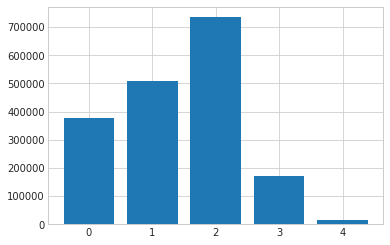

In [63]:
total_count = []

for index, traffic_period in enumerate(traffic_periods):
    total_count.append(traffic_period['number_people'].sum())
print(total_count)
plt.bar(x = range(len(total_count)), height = total_count)

Ignoring the first and the last period, based on the above notes, an interesting observation we can make from this plot is that in the Nov'15-Mar'16 period, the total number of workout sessions was more than twice that number in the same period of the next year (Nov'16-Mar'17). Said differently, the number of session workouts dropped by more than half one year after.

### Monthly statistics
We will increase the granularity of our analysis on a monthly basis.

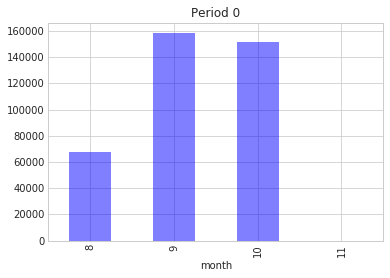

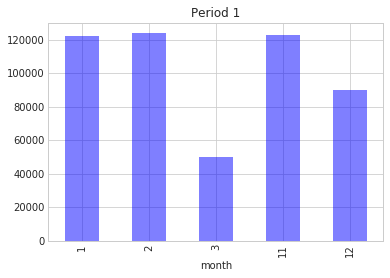

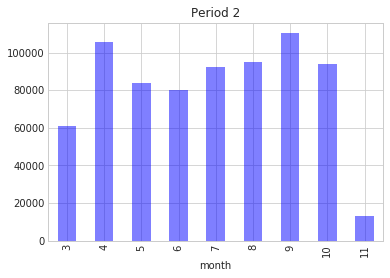

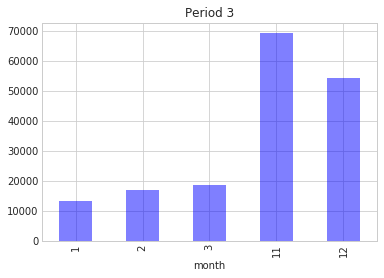

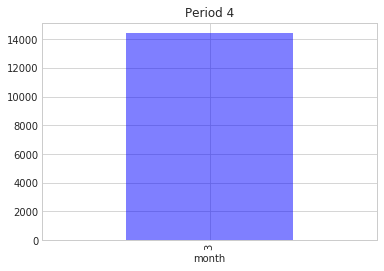

In [64]:
def plot_monthly_stats(traffic_period, index):
    #display(traffic_period.groupby('month')['number_people'].agg('sum'))
    traffic_period.groupby('month')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5)
    plt.title(f"Period {index}")
    plt.show()
    #traffic_period.hist(column = 'number_people', by='month')
for index, traffic_period in enumerate(traffic_periods):
    plot_monthly_stats(traffic_period, index)

# One month before and after DST
Let's now focus our analysis only on the month before and after the hour change, in order to look for more interesting pattern changes. 

In [65]:
for index in range(len(traffic_periods) - 1):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    print(f"Time change #{index}")
    print(f"Data points one month before: {len(one_month_before_dst)}")
    print(f"Data points one month after: {len(one_month_after_dst)}")

Time change #0
Data points one month before: 2934
Data points one month after: 2905
Time change #1
Data points one month before: 2905
Data points one month after: 2948
Time change #2
Data points one month before: 4124
Data points one month after: 4212
Time change #3
Data points one month before: 1384
Data points one month after: 666


We will ignore the last change, becaue we only have 8 days available on the period after the March 2017 time change, and not enough data points.
In order to visualise this data, we could plot the distrubtion of the number of people on every day of the week. That makes sense from the perspective of our data domain (since most of the workouts programs are tailored on a week by week basis - ie Monday - Leg day, Friday - Arms day 💪)

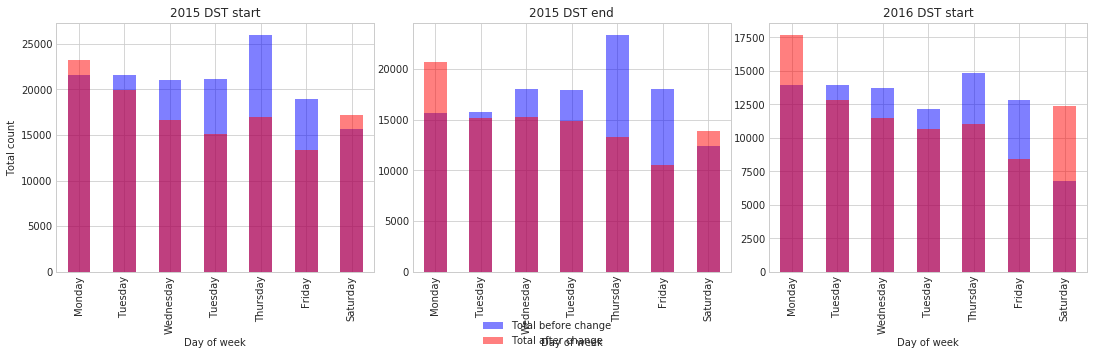

In [66]:
fig, ax = plt.subplots(1, len(traffic_periods) - 2, figsize = (15, 4))
fig.tight_layout()
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    one_month_before_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5, ax = ax[index])
    one_month_after_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='red', alpha=0.5, ax = ax[index])
    ax[index].set_title(f"{period_names[index]}")
    ax[index].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    ax[index].set_xlabel("Day of week")
ax[0].set_ylabel("Total count")
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, ['Total before change', 'Total after change'], loc='lower center')
fig.savefig('total_before_after.png', bbox_inches = 'tight')

We can see the results are pretty consistent. The distributions skews to the left, perhaps because people are thinking about going to the gym as early as possible (the peak is not Monday, not Thursday). We can think of this as the "New Year's Resolution" effect, when people are very motivated to start going to the gym and eating healthy right after the New Year's Eve, but they loose momentun in the following months, perhaps returning to normal, as soon as the NY vibe is gone.

## Heatmaps

Let's now try to plot a heatmap for each day of the week and for each hour.

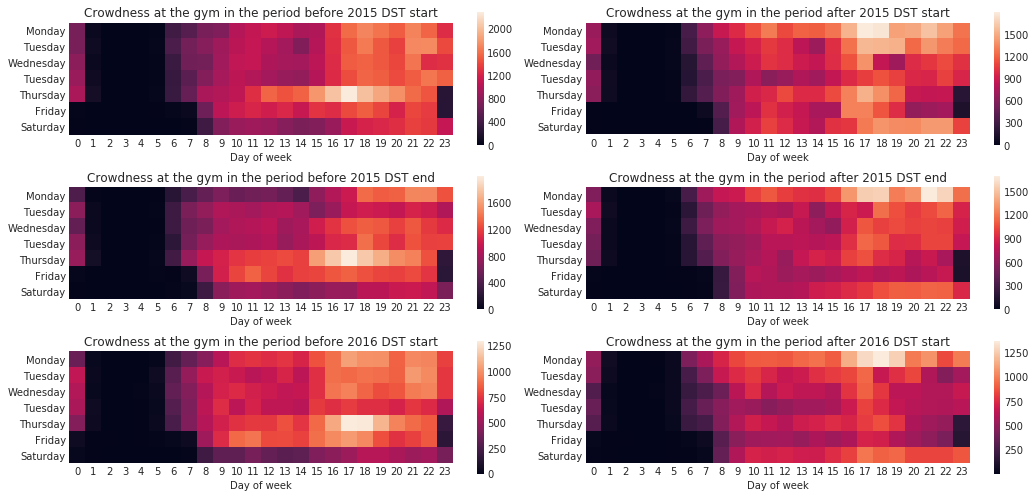

In [67]:
def plot_heatmap(df, index, ax, after = False, cbar = False):
    myMap = np.zeros(shape = [7, 24])
    for row in df.iterrows():
        myMap[row[1]['day_of_week'], row[1]['hour']] += row[1]['number_people']
    sns.heatmap(myMap, square=True, ax = ax, cbar = cbar)
    plt.tight_layout()
    if after:
        ax.set_title(f"Crowdness at the gym in the period after {period_names[index]}")
    else:
        ax.set_title(f"Crowdness at the gym in the period before {period_names[index]}")
    ax.set_xlabel("Day of week")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.set_yticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)

fig, ax = plt.subplots(len(traffic_periods) - 2, 2, figsize = (15, 7))
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    plot_heatmap(one_month_before_dst, index, ax[index, 0], cbar = True)
    plot_heatmap(one_month_after_dst, index, ax[index, 1], after = True, cbar = True)
fig.savefig("heatmap_crowndess.png", bbox_inches = 'tight')

It can be seen from these heatmaps that the number of coming early in the morning (6am) increases after the DST - which makes sense, and we were expecting that.

__A very interesting pattern that we notice is that on every change, the highest traffic at the gym before the change was always on Thursdays (white squares) afternoon, between 14-20, and the cluster after was always on Mondays on pretty much the same period.__

Let's now aggregate the days based on the hours.

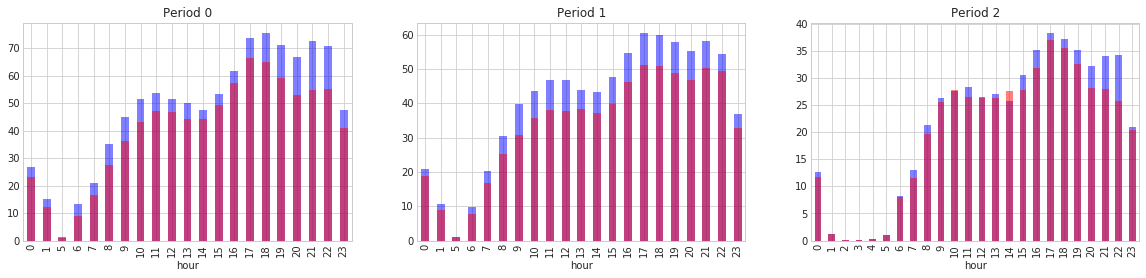

In [68]:
_, ax = plt.subplots(1, len(traffic_periods) - 2, figsize = (20, 4))
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    one_month_before_dst.groupby('hour')['number_people'].mean().plot.bar(color='blue', alpha=0.5, ax = ax[index])
    one_month_after_dst.groupby('hour')['number_people'].mean().plot.bar(color='red', alpha=0.5, ax = ax[index])
    ax[index].set_title(f"Period {index}")

We can see that the distribution of the mean number of people on each our is decreasing with some very very rare cases. One explication can be that most of the people's [sleep is affected by the irregularity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2718885/). Indeed, used to sleep $X$ number of hours and then one day sleeping $X + 1$ hours might actually perturb our sleep, and people might try to overcome this fatigue by something different than sport. Another potetial explanation can be given by the fact that since the gym is in the UC Berkely campus, the students and the mid-term exams period starts in November, students use DST as a 'breaking point' to stop going to the gym for a while, and study more.

Let's further see the correlations of the features before and after the changes.

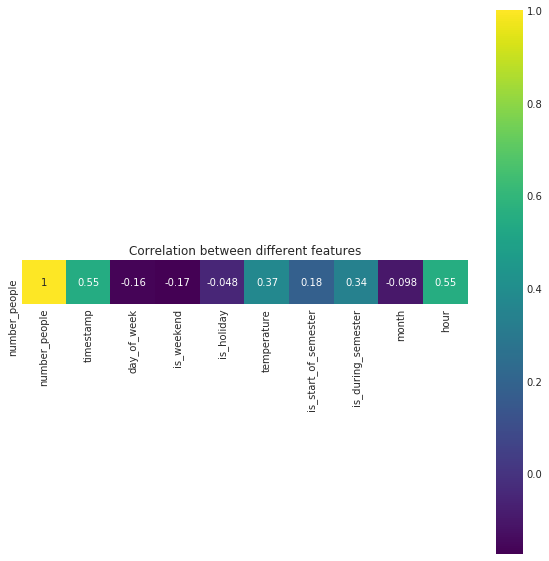

In [69]:
def show_correlation(df, ax = None, title = 'Correlation between different features'):
    correlation = df.corr()[:1]
    plt.figure(figsize=(10,10))
    if ax:
        sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis', ax = ax)
    else:
        ax = sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')

    ax.set_title(title)
show_correlation(traffic_data)

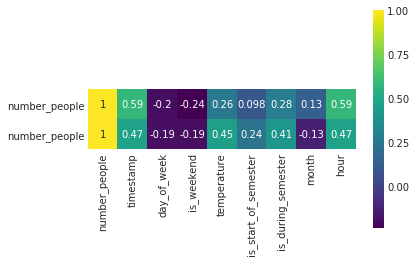

In [70]:
for index in range(1):#len(traffic_periods) - ):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    period_before = period_before.drop(columns = ['is_holiday'])
    period_after = period_after.drop(columns = ['is_holiday'])
    corr = pd.concat([period_before.corr()[:1], period_after.corr()[:1]], axis=0)
    sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='viridis')
plt.savefig("correlation.png", bbox_inches='tight')

We can see that the correlation before (the top row) and after (the bottom row) have changed. First, the hour seems not to be much correlated, but the temperature does seem to be more correlated. As stated earlier, the fact that the **is_start_semester** is very correlated with the number of peple.